In [1]:
# task1: apply noise
# task2: transform to gate basis
# task3: implement quantum fourier transform for adding two numbers
# task4:
#  - implement a quantum circuit that adds two numbers
#  - build a function that transforms a general quantum circuit to the gate basis
#  - apply noise
#  - use different noise models and compare the results

# gate basis: {cx, id, rz, sx, x}
# cnot, identity, z-rotation, sqrt-x, x

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy as np
from qiskit.circuit.library import CU1Gate, XGate, YGate, ZGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_distribution
from qiskit.compiler import transpile
import numpy as np
import random

In [3]:
def change_basis(qc, simulator, basis_gates):
    return transpile(qc, simulator, basis_gates=basis_gates, optimization_level=3)

In [4]:
def noise_model(qc, alpha, beta, noise_level):
    # alpha: Probability of having a random Pauli operator acting on the qubit after a one-qubit gate
    # beta: Probability of having a random Pauli operator acting on the qubit after a two-qubit gate
    # qc = qc.decompose()
    paulis = [XGate(), YGate(), ZGate()]
    noisy_qc = QuantumCircuit(*qc.qregs, *qc.cregs)

    # randomly choose a pauli operator to apply after each gate
    alpha_index = np.random.randint(0, len(paulis), size=noise_level)
    beta_index = np.random.randint(0, len(paulis), size=noise_level)

    alpha_prob = np.random.rand()
    beta_prob = np.random.rand()

    # check the number of 1 and 2 qubit gates
    q1_indices = []
    q1_qubits = []
    q2_indices = []
    q2_qubits = []
    for i, (instr, qargs, _) in enumerate(qc.data):
        if instr.name == "measure":
            break
        if instr.num_qubits == 1:
            # append the index of the gate to the list and which qubit it acts on
            q1_indices.append(i)
            q1_qubits.append([qargs[0]])
        if instr.num_qubits == 2:
            q2_indices.append(i)
            q2_qubits.append([qargs[np.random.randint(0, 2)]])

    # # apply noise to the circuit
    # choose a random index from the list of 1 and 2 qubit gates
    chosen_1q_gate = [random.choice(q1_indices) for _ in range(noise_level)]
    chosen_2q_gate = [random.choice(q2_indices) for _ in range(noise_level)]

    alpha_counter = 0
    beta_counter = 0
    for i, (instr, qreg, creg) in enumerate(qc.data):
        noisy_qc.append(instr, qreg, creg)
        if i in chosen_1q_gate and alpha_prob < alpha:
            noisy_qc.append(
                paulis[alpha_index[alpha_counter]], q1_qubits[q1_indices.index(i)]
            )
            alpha_counter += 1
        if i in chosen_2q_gate and beta_prob < beta:
            noisy_qc.append(
                paulis[beta_index[beta_counter]], q2_qubits[q2_indices.index(i)]
            )
            beta_counter += 1

    return noisy_qc

In [5]:
def qft(na, nb):
    qc = QuantumCircuit(na)
    curr = -1
    for _ in range(nb):
        l = 2
        qc.h(curr)
        for j in range(curr - 1, -na - 1, -1):
            control = j
            target = curr
            qc.append(CU1Gate(np.pi / 2 ** (l - 1)), [control, target])
            l += 1
        curr -= 1
    qc.h(curr)
    for i in range(na // 2):
        qc.swap(i, na - 1 - i)
    return qc.to_gate()

In [6]:
def adder(na, nb):
    curr = -na
    qc = QuantumCircuit(na + nb)
    for i in range(na):
        if i == 0:
            l = 2
            for j in range(nb):
                control = j
                target = curr
                qc.append(CU1Gate(np.pi / 2 ** (l - 1)), [control, target])
                l += 1
        else:
            l = 1
            control = i - 1
            for j in range(nb - i + 1):
                target = curr
                qc.append(CU1Gate(np.pi / 2 ** (l - 1)), [control, target])
                l += 1
                control += 1
        curr += 1
    return qc.to_gate()

In [7]:
def QFT_adder(a: str, b: str):
    n = max(len(a), len(b))
    # pad a and b with zeros
    a = a.zfill(n)
    b = b.zfill(n)
    na = n + 1
    nb = n
    aqreg = QuantumRegister(na)
    bqreg = QuantumRegister(nb)
    areg = ClassicalRegister(na)
    qc = QuantumCircuit(bqreg, aqreg, areg)

    # initialize a and b
    for i in range(na - 1):
        if a[i] == "1":
            qc.x(aqreg[na - i - 2])

    for i in range(nb):
        if b[i] == "1":
            qc.x(bqreg[i])

    qc.append(qft(na, nb), aqreg)
    qc.barrier()

    qc.append(adder(na, nb), [*bqreg, *aqreg])

    qc.append(qft(na, nb).inverse(), aqreg)
    qc.barrier()

    qc.measure(aqreg, areg)

    return qc

In [8]:
a = "001"
b = "111"
qc = QFT_adder(a, b)
# qc.decompose().draw(output="mpl")

In [9]:
qc_transpiled = change_basis(qc, AerSimulator(), ["cx", "id", "rz", "sx", "x"])

the result of adding 1 and 7 is 8


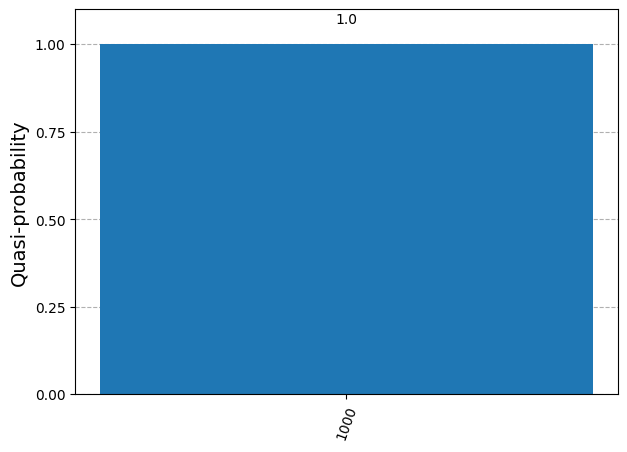

In [10]:
job = AerSimulator().run(qc_transpiled, shots=1024)
counts = job.result().get_counts(qc_transpiled)
# highest probability state
result = int(max(counts, key=counts.get), 2)
print(f"the result of adding {int(a,2)} and {int(b,2)} is {result}")
plot_distribution(counts)

In [11]:
# noisy_qc = noise_model(qc.decompose(), 1, 1, noise_level=10)
noisy_qc = noise_model(qc_transpiled, 0.5, 0.5, noise_level=10)
# noisy_qc.draw(output="mpl")

the result of adding 1 and 7 is 12


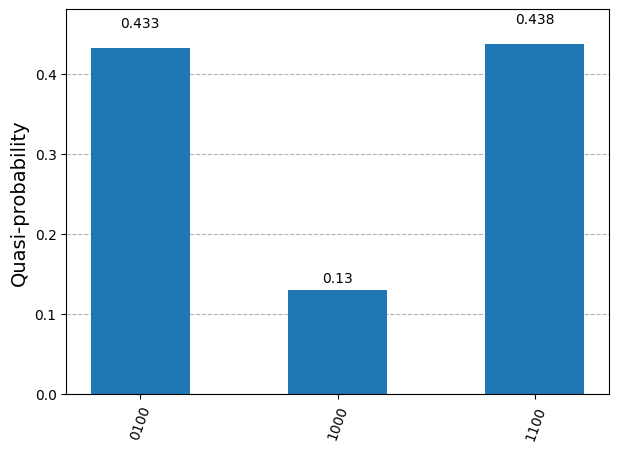

In [12]:
job = AerSimulator().run(noisy_qc, shots=1024)
counts = job.result().get_counts(noisy_qc)
# highest probability state
result = int(max(counts, key=counts.get), 2)
print(f"the result of adding {int(a,2)} and {int(b,2)} is {result}")
plot_distribution(counts)